# Annual Message to the Congress on the State of the Union

In [1]:
# Libraries and modules
import requests
from requests import get
from bs4 import BeautifulSoup 
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter 
import itertools
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora, similarities
from gensim.models import TfidfModel
from scipy.cluster import hierarchy
from nltk.stem import PorterStemmer
import pickle
import warnings

In [2]:
# Get the url
url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union"
response = requests.get(url)

# Find and store the table
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
table

<table border="1" cellpadding="0" cellspacing="0" class="table-responsive">
<thead>
<tr>
<td colspan="14" style="text-align: center;"><a id="Table of SOTU" name="Table of SOTU"><strong>Table of All State of the Union Messages and Addresses</strong></a></td>
</tr>
<tr>
<td style="text-align: center;"><strong><span>President</span></strong></td>
<td style="text-align: center;"><strong>Years of term</strong></td>
<td colspan="5" rowspan="1" style="text-align: center;"><strong> Delivered as a Speech (Address)</strong></td>
<td colspan="8" rowspan="1" style="text-align: center;"><strong>            Delivered as a Written Message</strong></td>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: center; height: 16px;"> </td>
<td style="text-align: center; height: 16px;"> </td>
<td style="text-align: center; height: 16px;">1st</td>
<td style="text-align: center; height: 16px;">2nd</td>
<td style="text-align: center; height: 16px;">3rd</td>
<td style="text-align: center; height: 16px;">4th</td>


In [3]:
# Find the first link in each row.
links = []

if table.findAll("tr"):
    trs = table.findAll('tr')  
    for tr in trs:
        try:
            link = tr.find('a')['href'] # Find the first link in a row
            links.append(link) # Append that link to the links list.
        except:
                pass
else:
    pass

# Select the links that are needed
links_needed = links[0:22]
links_needed

['https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-3',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=123408',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=102826',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=85753',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=58746',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=29643',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=53358',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=47232',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=16660',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=38069',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=43425',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=30856',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=4938',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=4327',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=2921',
 'https://www.presidency.ucsb.edu/ws/index.php?pid=26907',
 'https://www.presidency.u

In [4]:
# List of presidents
name =['2021Biden','2017Trump','2013Obama','2009Obama','2005WBush','2001WBush','1997Clinton','1993Clinton','1989Bush',
        '1985Reagan','1981Reagan','1978Carter','1975Ford','1974Nixon','1970Nixon','1965Johnson','1964Johnson','1961Keenedy',
        '1957Eisenhower','1953Eisenhower','1949Truman','1947Truman']

In [5]:
# Pre-process data
prevspeech=[]
speech=[]

for i,j in zip(links_needed,name):
    # Get the speech from url and make it a beautiful soup :)
    page_data = requests.get(i)
    page_data.encoding = 'utf-8'
    soup = BeautifulSoup(page_data.text, "html.parser")
    block = soup.find("div",{'class':"field-docs-content"}).getText()
    prevspeech.append(block)
    
    # Tokenize
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(block)

    # Eliminate capital letters
    words = [token.lower() for token in tokens]

    # Choose words that are not Stop words,added some manually
    sw = nltk.corpus.stopwords.words('english') + ['toward','also','upon','today','first','shall','ago','much','full','ask','nation','national','ever','look','back','time','act','said','think','going','get','set','president','mr','mrs','must','percent','america','american','americans','year','years','session','new','know','us','every','many','let','tonight','congress','program','country','people','one','world','united','states','government','make','plan']
    words_ns = [word for word in words if word not in sw]
    speech.append(words_ns)
    #15-20 are random numbers because almost all of the speeches started the same way
    print(words_ns[10:20])

['hall', 'laughter', 'anyway', 'thank', 'madam', 'speaker', 'madam', 'vice', 'words', 'podium']
['history', 'month', 'reminded', 'path', 'towards', 'civil', 'rights', 'work', 'still', 'remains']
['kennedy', 'declared', 'chamber', 'constitution', 'makes', 'rivals', 'power', 'partners', 'progress', 'task']
['men', 'women', 'great', 'chamber', 'speak', 'frankly', 'directly', 'men', 'women', 'sent']
['great', 'privilege', 'placed', 'office', 'votes', 'serve', 'privilege', 'share', 'newly', 'elected']
['thank', 'invitation', 'speak', 'formally', 'invite', 'could', 'close', 'vote', 'laughter', 'vice']
['inviting', 'come', 'challenge', 'great', 'peacetime', 'history', 'action', 'meet', 'challenge', 'prepare']
['giving', 'long', 'speech', 'laughter', 'presidents', 'speak', 'podium', 'typically', 'comment', 'range']
['3', 'weeks', 'joined', 'west', 'front', 'building', 'looking', 'monuments', 'proud', 'past']
['union', 'pleased', 'report', '4', 'effort', 'brought', 'forth', 'renewed', 'stronger

## Top 10 most 'meaningful' words

In [6]:
top_words_list = []
for item in speech:
    count = Counter(item)
    top10 = count.most_common(10)
    top_words_list.append(top10)

speech_df = pd.DataFrame({
    'President' : name,
     'top_words' : top_words_list
    })

speech_df[[1,2,3,4,5,6,7,8,9,10]] = pd.DataFrame(speech_df['top_words'].tolist(), index=speech_df.index)
speech_df.drop(['top_words'], inplace=True, axis=1)

speech_df

,President,1,2,3,4,5,6,7,8,9,10
0,2021Biden,"(jobs, 45)","(democracy, 17)","(care, 17)","(help, 15)","(1, 14)","(days, 14)","(right, 14)","(families, 14)","(made, 13)","(tax, 13)"
1,2017Trump,"(great, 16)","(citizens, 11)","(thank, 10)","(work, 10)","(across, 10)","(jobs, 9)","(want, 9)","(health, 9)","(since, 8)","(children, 8)"
2,2013Obama,"(jobs, 32)","(work, 20)","(need, 18)","(energy, 18)","(like, 17)","(families, 17)","(even, 16)","(right, 16)","(job, 15)","(high, 15)"
3,2009Obama,"(economy, 22)","(health, 20)","(care, 18)","(energy, 14)","(jobs, 14)","(education, 14)","(budget, 13)","(recovery, 12)","(crisis, 11)","(day, 11)"
4,2005WBush,"(security, 29)","(freedom, 20)","(social, 18)","(iraq, 14)","(workers, 14)","(terror, 14)","(system, 13)","(benefits, 13)","(retirement, 12)","(economy, 11)"
5,2001WBush,"(budget, 26)","(tax, 20)","(care, 15)","(social, 15)","(security, 15)","(money, 15)","(energy, 13)","(health, 13)","(good, 12)","(work, 12)"
6,1997Clinton,"(children, 24)","(work, 21)","(budget, 17)","(challenge, 16)","(century, 16)","(welfare, 15)","(education, 15)","(school, 15)","(4, 14)","(best, 14)"
7,1993Clinton,"(care, 24)","(jobs, 24)","(work, 23)","(tax, 22)","(say, 21)","(health, 21)","(deficit, 20)","(investment, 18)","(cut, 15)","(believe, 14)"
8,1989Bush,"(budget, 17)","(future, 15)","(work, 12)","(help, 11)","(need, 11)","(hope, 10)","(better, 9)","(drugs, 9)","(give, 8)","(propose, 8)"
9,1985Reagan,"(freedom, 20)","(tax, 16)","(growth, 14)","(economy, 14)","(lives, 11)","(great, 11)","(help, 11)","(defense, 11)","(well, 10)","(free, 10)"


First period (Truman to Johnson) was focus on recovering the economy from the war (jobs, security, prospecity). Then, Nixon worked to ease Cold war 

## Topic analysis

In [7]:
# Build a table to mirror structure of example
df = pd.DataFrame({'President':name,'Speech':prevspeech})
df.head()

,President,Speech
0,2021Biden,\nThe President. Thank you. Thank you. Thank y...
1,2017Trump,"\nThank you very much. Mr. Speaker, Mr. Vice P..."
2,2013Obama,"\nPlease, everybody, have a seat. Mr. Speaker,..."
3,2009Obama,"\nMadam Speaker, Mr. Vice President, Members o..."
4,2005WBush,"\nMr. Speaker, Vice President Cheney, Members ..."


In [8]:
manual_stops = ['mr','mrs','must','percent','america','american','year','years','session']
def add_stopword(word):
    manual_stops.append(word)

def remove_stops(word_list):
    stop_words = nltk.corpus.stopwords.words('english')
    all_stops = stop_words + manual_stops
    removed_list = [word for word in word_list if word not in all_stops]
    return removed_list

# Remove punctuation

df['Speech_processed'] = df['Speech'].map(lambda x: re.sub('[^A-Za-z]/g', '', x))
df['Speech_processed'] = df['Speech_processed'].map(lambda x: re.sub('[,\.!?]', '', x))
df['Speech_processed'] = df['Speech_processed'].map(lambda x:  re.sub('[\n]', '', x) )
# Convert to lowercase
df['Speech_processed'] = df['Speech_processed'].map(lambda x: x.lower())

#df['remove_stop'] = df['word_list'].apply(remove_stops)

# Print the processed information of the first rows 
df.head()

,President,Speech,Speech_processed
0,2021Biden,\nThe President. Thank you. Thank you. Thank y...,the president thank you thank you thank you go...
1,2017Trump,"\nThank you very much. Mr. Speaker, Mr. Vice P...",thank you very much mr speaker mr vice preside...
2,2013Obama,"\nPlease, everybody, have a seat. Mr. Speaker,...",please everybody have a seat mr speaker mr vic...
3,2009Obama,"\nMadam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members of con...
4,2005WBush,"\nMr. Speaker, Vice President Cheney, Members ...",mr speaker vice president cheney members of co...


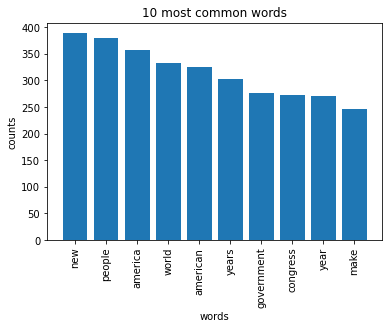

In [9]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Speech_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [10]:
# LDA
warnings.simplefilter("ignore", DeprecationWarning)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 4
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
america people years new american world nation year make congress americans help government security time

Topic #1:
people new year government tax world american jobs congress program years make energy work federal

Topic #2:
new american america people world country americans congress years time health nation work know make

Topic #3:
new world government people congress nation economic years federal time freedom defense american national nations


## Sentiments

In [11]:
# NLTK VADER for sentiment analysis

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
    'war':-80, #because it could be celebrating the end of the war
    #'iraq':-60
}

vader = SentimentIntensityAnalyzer()
vader.lexicon.update(new_words)

In [12]:
polarity=[]
compound=[]
for sentence in df['Speech_processed']:
    ss = vader.polarity_scores(sentence)
    polarity.append(ss)
    comp=vader.polarity_scores(sentence)['compound']
    compound.append(comp)

pd.set_option("display.precision", 8)
df_polarity = pd.DataFrame({'President':name,'Polarity':polarity,'Compound':compound})
df_polarity.head()

,President,Polarity,Compound
0,2021Biden,"{'neg': 0.157, 'neu': 0.708, 'pos': 0.135, 'co...",-1.0000
1,2017Trump,"{'neg': 0.159, 'neu': 0.652, 'pos': 0.189, 'co...",0.9495
2,2013Obama,"{'neg': 0.118, 'neu': 0.706, 'pos': 0.176, 'co...",0.9998
3,2009Obama,"{'neg': 0.14, 'neu': 0.713, 'pos': 0.147, 'com...",-0.9985
4,2005WBush,"{'neg': 0.173, 'neu': 0.634, 'pos': 0.193, 'co...",-0.9993


<AxesSubplot:title={'center':'Sentiment of each state of the union speech'}, xlabel='President'>

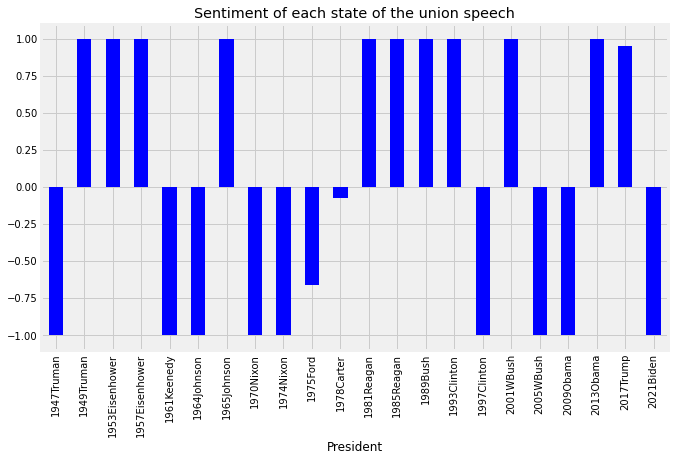

In [13]:
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = df_polarity.groupby(['President']).mean()
# Unstack the column ticker
#mean_c = mean_c.unstack('ticker')
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs("Compound", axis="columns")
# Plot a bar chart with pandas
TITLE = 'Sentiment of each state of the union speech'
COLORS = ['blue']
mean_c.plot.bar(figsize = (10, 6), title=TITLE,color=COLORS)

## Clusters

In [14]:
# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in speech]

# Save to pickle file
pickle.dump( texts_stem, open( "sofu/texts_stem2.p", "wb" ) )

# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load(open("sofu/texts_stem2.p", "rb"))

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

FileNotFoundError: [Errno 2] No such file or directory: 'sofu/texts_stem2.p'

In [ ]:
# Generate the tf-idf model
model = TfidfModel(bows)

In [ ]:
# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a DataFrame
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the DataFrame
sim_df.columns = name
sim_df.index = name

# Print the resulting matrix
sim_df.head()

In [ ]:
# Compute the clusters from the similarity matrix, using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')

# Display this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z,  leaf_font_size=8, labels=sim_df.index,  orientation="left")

# By time

### Similarity to Biden 2022

In [ ]:
# Get the speech of Biden in 2022
biden_speech = requests.get('https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-28')
biden_speech.encoding = 'utf-8'
bsoup = BeautifulSoup(biden_speech.text, "html.parser")
needed_block = bsoup.find("div",{'class':"field-docs-content"}).getText()
needed_block

In [ ]:
# Add the speech and the president name to the lists
prevspeech.append(needed_block)
name_add='2022Biden'
name.append(name_add)
name

In [ ]:
# Check
bidendf = pd.DataFrame({'President':name,'Speech':prevspeech})
bidendf.to_excel("speeches_file.xlsx")

In [ ]:
# Browse position of Biden 2022
for i in range(len(name)):
    if(name[i]=="2022Biden"):
        ori = i
    
# Print the stored index
print(str(ori))

In [ ]:
# Define a list of stop words
stoplist = nltk.corpus.stopwords.words('english') + ['mr.','mrs','must','percent','america','american','year','session']
#set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

# Convert the text to lower case 
txts_lower_case = [txt.lower() for txt in prevspeech]

# Transform the text into tokens 
txts_split = [txt.split() for txt in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[word for word in txt if word not in stoplist] for txt in txts_split]

# Print the first 20 tokens for Biden 2022 speech
texts[ori][0:20]

In [ ]:
# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Save to pickle file
pickle.dump( texts_stem, open( "sofu/texts_stem3.p", "wb" ) )

In [ ]:
# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load(open("sofu/texts_stem3.p", "rb"))

# Print the 20 first stemmed tokens from the 2022 Biden speech
print(texts_stem[ori][0:20])

In [ ]:
# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
biden_bows = [dictionary.doc2bow(text) for text in texts_stem]

# Print the first five elements of the 2022 Biden speech' BoW model
biden_bows[ori][0:5]

In [ ]:
# Generate the tf-idf model
biden_model = TfidfModel(biden_bows)

# Print the model for 2022 Biden Speech
model[biden_bows[ori]]

In [ ]:
# Compute the similarity matrix (pairwise distance between all texts)
biden_sims = similarities.MatrixSimilarity(biden_model[biden_bows])

# Transform the resulting list into a DataFrame
sim_bidendf = pd.DataFrame(list(biden_sims))

# Add the titles of the books as columns and index of the DataFrame
sim_bidendf.columns = name
sim_bidendf.index = name

# Print the resulting matrix
sim_bidendf.head()

In [15]:
%matplotlib inline

# Select the column corresponding to "2022Biden" 
v = sim_bidendf["2022Biden"]

# Sort by ascending scores
v_sorted = v.sort_values(ascending=True)

# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

# Modify the axes labels and plot title for better readability
plt.xlabel("Cosine distance")
plt.ylabel("")
plt.title("Most similar speech to the one given by Biden 2022")

NameError: name 'sim_bidendf' is not defined